# Accuracy Using a Classifier

In [0]:
%matplotlib inline
from fastai.vision import *
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import os

## Data and Imports

In [2]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/baseline-MNIST.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/featureLoss-MNIST.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/pixelShuffle-MNIST.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/preTrained-MNIST.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/preTrained_nonweights-MNIST.pt" .
  %cp "/content/drive/My Drive/autoencoder-training/progResize-MNIST.pt" .

  %cp "/content/drive/My Drive/autoencoder-training/baseline_model.py" .
  %cp "/content/drive/My Drive/autoencoder-training/model_layers.py" .
  %cp "/content/drive/My Drive/autoencoder-training/featureLoss_function.py" .
  %cp "/content/drive/My Drive/autoencoder-training/pixelShuffle_model.py" .
  %cp "/content/drive/My Drive/autoencoder-training/pretrainedModel.py" .
  %cp "/content/drive/My Drive/autoencoder-training/progressiveResizing_model.py" .
  image_path = "data"
  import baseline_model
  import model_layers
  import featureLoss_function
  import pixelShuffle_model
  import pretrainedModel
  import progressiveResizing_model
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
batchsize = 128

path = untar_data(URLs.MNIST)
data = ImageDataBunch.from_folder(path, train='training', valid='testing',size=32,ds_tfms=get_transforms(p_affine=0), bs = 128
                                 ).normalize(imagenet_stats)

## Training Classifier

In [4]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [5]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.582344,0.400117,0.130600,00:57


In [6]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-05
Min loss divided by 10: 2.29E-03


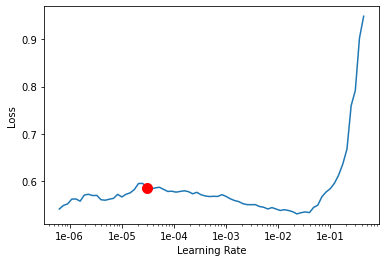

In [7]:
learn.recorder.plot(suggestion = True)

In [8]:
learn.fit_one_cycle(10, max_lr = 1e-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.420635,0.280551,0.089700,00:56
1,0.238128,0.155704,0.048900,00:56
2,0.151242,0.086455,0.029100,00:57
3,0.105593,0.068327,0.022300,00:58
4,0.091993,0.058217,0.019400,00:57
5,0.082500,0.054133,0.019900,00:58
6,0.063787,0.048322,0.016200,00:57
7,0.058982,0.043992,0.016000,00:57
8,0.050419,0.042294,0.014400,00:57
9,0.051128,0.040488,0.014800,00:57


In [9]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr = slice(1e-06, 1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.051136,0.041750,0.014700,01:00
1,0.054801,0.043176,0.014000,01:00
2,0.052525,0.039949,0.013300,01:03
3,0.043692,0.041654,0.015100,01:03
4,0.030942,0.036662,0.011200,01:02
5,0.031270,0.034035,0.011300,01:00
6,0.021032,0.033455,0.010700,01:00
7,0.014461,0.030001,0.009700,01:00
8,0.010388,0.029994,0.009300,01:00
9,0.009365,0.029438,0.008800,01:00


In [0]:
torch.save(learn.model, "baselineClassification.pt")
torch.save(learn.model, "/content/drive/My Drive/autoencoder-training/baselineClassificationMNIST.pt")

In [0]:
classifier = torch.load("baselineClassification.pt")

learn = Learner(data, classifier, metrics = [error_rate, accuracy])

In [33]:
learn.validate(learn.data.valid_dl)

[0.029437838, tensor(0.0088), tensor(0.9912)]

## Classifier Accuracy

### Baseline

In [0]:
class baseline(nn.Module):
    def __init__(self):
        super(baseline, self).__init__()

        self.autoencoder = torch.load("baseline-MNIST.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
baseline_evaluation = baseline()
learn = Learner(data, baseline_evaluation, metrics = [error_rate, accuracy])

In [13]:
learn.validate(learn.data.valid_dl)

[0.0360932, tensor(0.0100), tensor(0.9900)]

### FeatureLoss

In [0]:
class featureloss_mod(nn.Module):
    def __init__(self):
        super(featureloss_mod, self).__init__()

        self.autoencoder = torch.load("featureLoss-MNIST.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
featureloss_evaluation = featureloss_mod()
learn = Learner(data, featureloss_evaluation, metrics = [error_rate, accuracy])

In [16]:
learn.validate(learn.data.valid_dl)

[0.0425844, tensor(0.0114), tensor(0.9886)]

### Pretrained Models

#### Pretrained

In [0]:
class pretrained_weights(nn.Module):
    def __init__(self):
        super(pretrained_weights, self).__init__()

        self.autoencoder = torch.load("preTrained-MNIST.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
pretrained_weights_eval = pretrained_weights()
learn = Learner(data, pretrained_weights_eval, metrics = [error_rate, accuracy])

In [19]:
learn.validate(learn.data.valid_dl)

[0.074049965, tensor(0.0196), tensor(0.9804)]

#### Resnet

In [0]:
class resnet_model(nn.Module):
    def __init__(self):
        super(resnet_model, self).__init__()

        self.autoencoder = torch.load("preTrained_nonweights-MNIST.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
resnet_eval = resnet_model()
learn = Learner(data, resnet_eval, metrics = [error_rate, accuracy])

In [22]:
learn.validate(learn.data.valid_dl)

[0.1592535, tensor(0.0346), tensor(0.9654)]

### Pixel Shuffled

In [0]:
class pixelShuffle_model(nn.Module):
    def __init__(self):
        super(pixelShuffle_model, self).__init__()

        self.autoencoder = torch.load("pixelShuffle-MNIST.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
pixelShuffle_eval = pixelShuffle_model()
learn = Learner(data, pixelShuffle_eval, metrics = [error_rate, accuracy])

In [25]:
learn.validate(learn.data.valid_dl)

[0.04206144, tensor(0.0130), tensor(0.9870)]

### Progressive Resizing

In [0]:
class progResize_model(nn.Module):
    def __init__(self):
        super(progResize_model, self).__init__()

        self.autoencoder = torch.load("progResize-MNIST.pt")
        self.classifier = torch.load("baselineClassification.pt")
        self.mean = torch.tensor(imagenet_stats[0]).cuda()
        self.std = torch.tensor(imagenet_stats[1]).cuda()

    def forward(self, x):
        x = torch.clamp(self.autoencoder(x), min=0, max=1)
        x = (x - self.mean[...,None,None])/self.std[...,None,None]
        x = self.classifier(x)
        return x

In [0]:
progResize_eval = progResize_model()
learn = Learner(data, progResize_eval, metrics = [error_rate, accuracy])

In [30]:
learn.validate(learn.data.valid_dl)

[0.04356093, tensor(0.0123), tensor(0.9877)]